# Data access using the low-level API

In [4]:
import aeon
import pandas as pd
from aeon.analysis.utils import distancetravelled
from aeon.analysis.plotting import heatmap
from aeon.schema.schemas import social02
from aeon.metadata.social_02 import ExperimentMetadata
from matplotlib import pyplot as plt

In this example, we are using the [**Single mouse in a foraging assay**](https://doi.org/10.5281/zenodo.13881884) sample dataset. The root path is the directory containing the entire dataset, including all epochs and chunks of data for all streams of all devices. If your local dataset is in a different location, please change the value below before running the cells below.

You can also run this notebook online from [`works.datajoint.com`](https://works.datajoint.com/) using the following credentials:
 - Username: aeondemo
 - Password: aeon_sfn2024

In [2]:
root = '/data/raw/AEON3/social0.2/'

## Experiment metadata

Information about the location and configuration of all devices can be extracted from the `Metadata.yml` file. The `ExperimentMetadata` class provides a convenient API for parsing and accessing this metadata to access video frame rate, pixel to standard unit conversions, etc.

In [3]:
metadata = aeon.load(root, social02.Metadata)['metadata'].iloc[0]
experiment = ExperimentMetadata(metadata)
arena = experiment.arena

## Position tracking

The `social02` schema is used with `aeon.load` to read stream data from different devices. Below we access the SLEAP pose data from `CameraTop` and convert pixel coordinates to standard units using the `point_to_cm` function from arena metadata.

In [4]:
pose = aeon.load(root, social02.CameraTop.Pose)
position_cm = experiment.arena.point_to_cm(pose[['x', 'y']])

The low-level API also contains utility functions for data visualization and exploration. Below we use `heatmap` to display a 2D histogram of the position data over the entire dataset period.

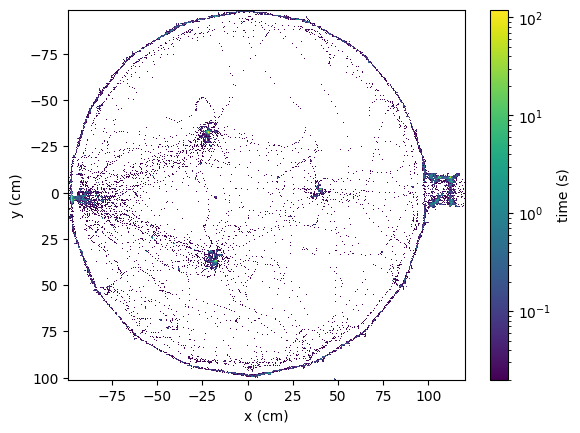

In [5]:
fig, ax = plt.subplots(1, 1)
heatmap(position_cm, experiment.video.global_fps, bins=500, ax=ax)
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

## Foraging activity

In this experiment there are three foraging patches. For each patch we access below the wheel movement data and state transitions when a pellet is delivered.

In [6]:
patches = ["Patch1", "Patch2", "Patch3"]
patch_encoder = {patch: aeon.load(root, social02[patch].Encoder) for patch in patches}
patch_distance = {patch: distancetravelled(patch_encoder[patch].angle, radius=experiment.patch1.radius_cm / 100) for patch in patches}
pellet_deliveries = {patch: aeon.load(root, social02[patch].DepletionState).groupby(pd.Grouper(freq='1s')).first().dropna() for patch in patches}

RFID tag readers are also located at various points of the environment and can be accessed using the same API.

In [7]:
rfids = ["Patch1Rfid", "Patch2Rfid", "Patch3Rfid", "NestRfid1", "NestRfid2", "GateRfid"]
rfid_events = {rfid: aeon.load(root, social02[rfid].RfidEvents) for rfid in rfids}

Below we summarize all patch and RFID activity. Note we can directly align time across all plots since data is synchronized at source.

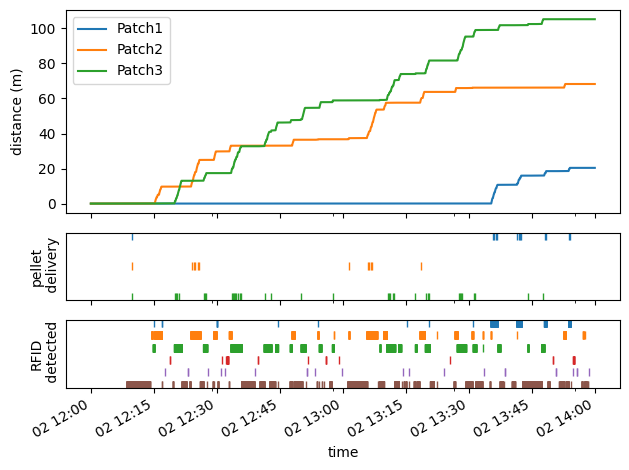

In [8]:
fig, axes = plt.subplots(3, 1, sharex=True, height_ratios=[0.6, 0.2, 0.2])

for i, patch in enumerate(patches):
    # plot distance travelled and pellet delivery events
    patch_distance[patch].plot(ax=axes[0], label=patch, x_compat=True)
    pellet_deliveries[patch].assign(patch_index=-i).patch_index.plot(ax=axes[1], style='|', label=patch)

for i, rfid in enumerate(rfids):
    # plot RFID detection events
    rfid_events[rfid].assign(rfid_index=-i).rfid_index.plot(ax=axes[2], style='|', label=rfid)

axes[0].set_ylabel('distance (m)')
axes[1].set_ylabel('pellet\n delivery')
axes[2].set_ylabel('RFID\n detected')
axes[1].set_yticks([])
axes[2].set_yticks([])
axes[0].legend()
plt.tight_layout()
plt.show()


## Event-triggered analysis

Having the same time reference for all data is also useful for quick exploration of correlations. Below we correlate wheel movement data with pellet delivery events by performing a direct outer join between the two tables and grouping by event count.

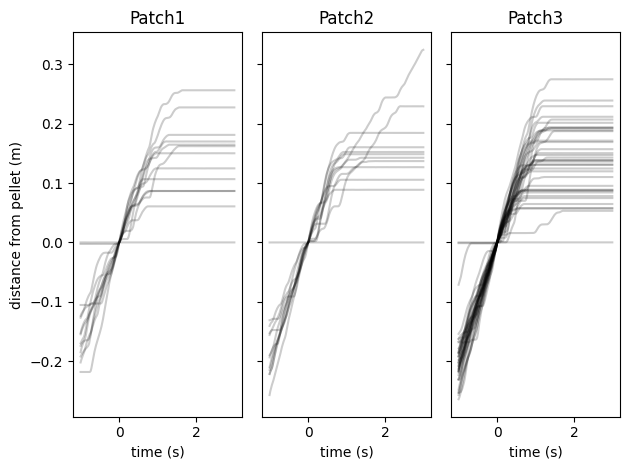

In [51]:
fig, axes = plt.subplots(1, 3, sharey=True)

for i, patch in enumerate(patches):
    # get patch state at each pellet delivery
    patch_state = pellet_deliveries[patch].assign(count=pellet_deliveries[patch].offset.notna().cumsum())
    
    # correlate patch state with wheel data with a time delay
    foraging_state = patch_state.shift(freq='-1s').join(patch_distance[patch], how='outer').ffill().dropna()

    # group wheel data by pellet delivery and align on first second
    for _, v in foraging_state.groupby("count"):
        foraging_distance = v.head(200).distance.to_frame()
        foraging_distance -= foraging_distance.iloc[50]
        foraging_distance.index = (foraging_distance.index - foraging_distance.index[50]).total_seconds()
        foraging_distance.distance.plot(ax=axes[i], style='k', alpha=0.2)
    axes[i].set_title(patch)
    axes[i].set_ylabel('distance from pellet (m)')
    axes[i].set_xlabel('time (s)')

plt.tight_layout()
plt.show()

## Video analysis

`aeon.io.video` includes utilities for easily extracting raw video frames and movies aligned to the data.

In [71]:
from typing import cast
from aeon.io.video import frames

camera_frames = {
    "CameraTop": aeon.load(root, social02.CameraTop.Video),
    "CameraPatch1": aeon.load(root, social02.CameraPatch1.Video),
    "CameraPatch2": aeon.load(root, social02.CameraPatch2.Video),
    "CameraPatch3": aeon.load(root, social02.CameraPatch3.Video),
    "CameraNest": aeon.load(root, social02.CameraNest.Video),
}

Below we extract the normalized wheel distance before and after a single pellet delivery on a specified patch. As above we normalize time in seconds aligned to pellet delivery and distance in meters from pellet.

In [115]:
single_patch = "Patch2"
delivery_index = 6
before_delta = pd.Timedelta("1s")
after_delta = pd.Timedelta("3s")

single_pellet = pellet_deliveries[single_patch].iloc[delivery_index]
delivery_time = cast(pd.Timedelta, single_pellet.name)
before = delivery_time - before_delta
after = delivery_time + after_delta
foraging_distance = patch_distance[single_patch].loc[before:after] - patch_distance[single_patch].loc[delivery_time]
foraging_distance.index = (foraging_distance.index - delivery_time).total_seconds()

Next we extract the video frames corresponding to specific moments in the pellet delivery sequence. Note how `reindex` is used with `ffill` to get the closest frame following the desired frame times.

Given a data frame of video frame metadata, the `frames` function will open and decode all the corresponding frame data as a `numpy.array`.

In [116]:
# get video frames at specific offsets from delivery time
frame_deltas_seconds = [-0.5, 1, 2]
frame_times = [delivery_time + pd.Timedelta(delta, unit="s") for delta in frame_deltas_seconds]
frame_metadata = camera_frames[f"Camera{single_patch}"].reindex(frame_times, method="ffill")
bout_frames = list(frames(frame_metadata))

Finally we arrange a mosaic plot drawing each individual frame from left to right and annotate the distance plot with the frame times.

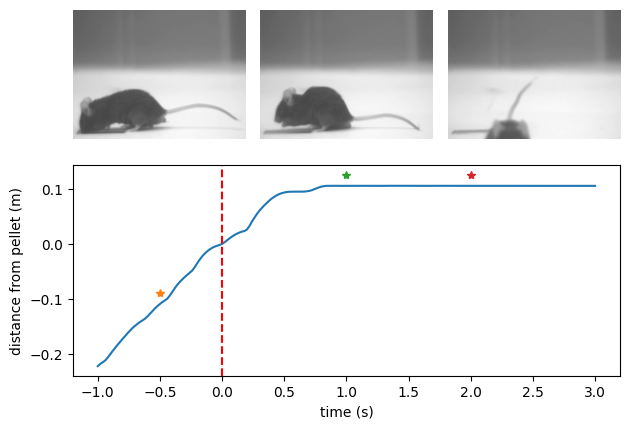

In [117]:
fig, axes = plt.subplot_mosaic([["A", "B", "C"], ["D", "D", "D"]])
foraging_distance.plot(ax=axes["D"])
for i, frame_delta in enumerate(frame_deltas_seconds):
    ax_index = chr(ord("A") + i)
    axes[ax_index].imshow(bout_frames[i])
    axes[ax_index].set_axis_off()
    axes["D"].plot(frame_delta, foraging_distance.loc[frame_delta] + 0.02, "*")
axes["D"].axvline(0, linestyle="--", color="red")
axes["D"].set_ylabel("distance from pellet (m)")
axes["D"].set_xlabel("time (s)")
plt.tight_layout()
plt.show()